<a href="https://colab.research.google.com/github/zypaoo/NCKH-DuyBao/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORT LIBRARY**

In [6]:
!pip install imbalanced-learn
!pip install category_encoders
!pip install pytorch-tabnet
!pip install tabtransformertf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import category_encoders as ce
from imblearn.over_sampling import SMOTE, SVMSMOTE
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import build_categorical_prep
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

# **LOAD DATA**

In [7]:
churn_data = pd.read_csv("/content/drive/MyDrive/Dataset_NCKH/Bảo Link2.csv")

In [8]:
churn_data

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL             No  ...   
1             Yes                No             DSL            Yes  ...   
2             Yes                No             DSL            Yes  ...   
3              No  No phone service             DSL            Yes  ...   
4             Yes                No     Fiber optic             No  ...   
...           ...               ...             ...            ...  ...   
7038          Yes               Yes             DSL            Yes  ...   
7039          Yes               Yes     Fiber optic             No  ...   
7040           No  No phone service             DSL            Yes  ...   
7041          Yes               Yes     Fiber optic             No  ...   
7042          Yes                No     Fiber optic            Yes  ...   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod MonthlyCharges  TotalCharges  \
0                 Yes           Electronic check          29.85         29.85   
1                  No               Mailed check          56.95        1889.5   
2                 Yes               Mailed check          53.85        108.15   
3                  No  Bank transfer (automatic)          42.30       1840.75   
4                 Yes           Electronic check          70.70        151.65   
...               ...                        ...            ...           ...   
7038              Yes               Mailed check          84.80        1990.5   
7039              Yes    Credit card (automatic)         103.20        7362.9   
7040              Yes           Electronic check          29.60        346.45   
7041              Yes               Mailed check          74.40         306.6   
7042              Yes  Bank transfer (automatic)         105.65        6844.5   

     Churn  
0       No  
1       No  
2      Yes  
3       No  
4      Yes  
...    ...  
7038    No  
7039    No  
7040    No  
7041   Yes  
7042    No  

[7043 rows x 21 columns]

In [9]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
dataset = churn_data.copy()

# ***PREPROCESSING***

In [11]:
columns_to_drop = ['customerID']
dataset = dataset.drop(columns=columns_to_drop, errors='ignore')

In [12]:
dataset.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [13]:
dataset['TotalCharges'] = dataset['TotalCharges'].replace(' ', '0.0').astype(float)

In [14]:
def print_unique_col_values(dataset):
       for column in dataset:
            if dataset[column].dtypes=='object':
                print(f'{column}: {dataset[column].unique()}')

In [15]:
print_unique_col_values(dataset)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [16]:
dataset.replace('No internet service', 'No', inplace = True)
dataset.replace('No phone service', 'No', inplace = True)

In [17]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']

In [18]:
multi_cat_cols = [
    'InternetService',
    'Contract',
    'PaymentMethod'
]

In [19]:
binary_map = {
    'Yes': 1, 'No': 0,
    'Female': 1, 'Male': 0}
for col in binary_cols:
    dataset[col] = dataset[col].map(binary_map)

In [20]:
print_unique_col_values(dataset)

InternetService: ['DSL' 'Fiber optic' 'No']
Contract: ['Month-to-month' 'One year' 'Two year']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [21]:
dataset_ft= dataset.copy()

In [22]:
dataset_hash = pd.get_dummies(dataset,columns=['InternetService','Contract','PaymentMethod'], dtype=int)

In [23]:
dataset_hash

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          1              0        1           0       1             0   
1          0              0        0           0      34             1   
2          0              0        0           0       2             1   
3          0              0        0           0      45             0   
4          1              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038       0              0        1           1      24             1   
7039       1              0        1           1      72             1   
7040       1              0        1           1      11             0   
7041       0              1        1           0       4             1   
7042       0              0        0           0      66             1   

      MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0                 0               0             1                 0  ...   
1                 0               1             0                 1  ...   
2                 0               1             1                 0  ...   
3                 0               1             0                 1  ...   
4                 0               0             0                 0  ...   
...             ...             ...           ...               ...  ...   
7038              1               1             0                 1  ...   
7039              1               0             1                 1  ...   
7040              0               1             0                 0  ...   
7041              1               0             0                 0  ...   
7042              0               1             0                 1  ...   

      InternetService_DSL  InternetService_Fiber optic  InternetService_No  \
0                       1                            0                   0   
1                       1                            0                   0   
2                       1                            0                   0   
3                       1                            0                   0   
4                       0                            1                   0   
...                   ...                          ...                 ...   
7038                    1                            0                   0   
7039                    0                            1                   0   
7040                    1                            0                   0   
7041                    0                            1                   0   
7042                    0                            1                   0   

      Contract_Month-to-month  Contract_One year  Contract_Two year  \
0                           1                  0                  0   
1                           0                  1                  0   
2                           1                  0                  0   
3                           0                  1                  0   
4                           1                  0                  0   
...                       ...                ...                ...   
7038                        0                  1                  0   
7039                        0                  1                  0   
7040                        1                  0                  0   
7041                        1                  0                  0   
7042                        0                  0                  1   

      PaymentMethod_Bank transfer (automatic)  \
0                                           0   
1                                           0   
2                                           0   
3                                           1   
4                                           0   
...                                       ...   
7038                                        0   
7039                  

In [24]:
corr = dataset_hash.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

In [25]:
corr_with_churn = corr['Churn'].apply(abs).sort_values(ascending=False)
print(corr_with_churn)

Churn                                      1.000000
Contract_Month-to-month                    0.405103
tenure                                     0.352229
InternetService_Fiber optic                0.308020
Contract_Two year                          0.302253
PaymentMethod_Electronic check             0.301919
InternetService_No                         0.227890
TotalCharges                               0.198324
MonthlyCharges                             0.193356
PaperlessBilling                           0.191825
Contract_One year                          0.177820
OnlineSecurity                             0.171226
TechSupport                                0.164674
Dependents                                 0.164221
SeniorCitizen                              0.150889
Partner                                    0.150448
PaymentMethod_Credit card (automatic)      0.134302
InternetService_DSL                        0.124214
PaymentMethod_Bank transfer (automatic)    0.117937
PaymentMetho

In [26]:
low_corr_features = corr_with_churn[corr_with_churn < 0.05].index.tolist()
dataset_hash = dataset_hash.drop(columns=low_corr_features)
print(low_corr_features)

['MultipleLines', 'PhoneService', 'gender']


In [27]:
dataset_hash

SeniorCitizen  Partner  Dependents  tenure  OnlineSecurity  \
0                 0        1           0       1               0   
1                 0        0           0      34               1   
2                 0        0           0       2               1   
3                 0        0           0      45               1   
4                 0        0           0       2               0   
...             ...      ...         ...     ...             ...   
7038              0        1           1      24               1   
7039              0        1           1      72               0   
7040              0        1           1      11               1   
7041              1        1           0       4               0   
7042              0        0           0      66               1   

      OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
0                1                 0            0            0   
1                0                 1            0            0   
2                1                 0            0            0   
3                0                 1            1            0   
4                0                 0            0            0   
...            ...               ...          ...          ...   
7038             0                 1            1            1   
7039             1                 1            0            1   
7040             0                 0            0            0   
7041             0                 0            0            0   
7042             0                 1            1            1   

      StreamingMovies  ...  InternetService_DSL  InternetService_Fiber optic  \
0                   0  ...                    1                            0   
1                   0  ...                    1                            0   
2                   0  ...                    1                            0   
3                   0  ...                    1                            0   
4                   0  ...                    0                            1   
...               ...  ...                  ...                          ...   
7038                1  ...                    1                            0   
7039                1  ...                    0                            1   
7040                0  ...                    1                            0   
7041                0  ...                    0                            1   
7042                1  ...                    0                            1   

      InternetService_No  Contract_Month-to-month  Contract_One year  \
0                      0                        1                  0   
1                      0                        0                  1   
2                      0                        1                  0   
3                      0                        0                  1   
4                      0                        1                  0   
...                  ...                      ...                ...   
7038                   0                        0                  1   
7039                   0                        0                  1   
7040                   0                        1                  0   
7041                   0                        1                  0   
7042                   0                        0                  0   

      Contract_Two year  PaymentMethod_Bank transfer (automatic)  \
0                     0                                        0   
1                     0                                        0   
2                     0                                        0   
3                     0                                        1   
4                     0                                        0   
...                 ...                                      ...   
7038                  0                                        0   
7039                  0   

In [28]:
dataset_up1 = dataset_hash.copy()

In [29]:
dataset_up1

SeniorCitizen  Partner  Dependents  tenure  OnlineSecurity  \
0                 0        1           0       1               0   
1                 0        0           0      34               1   
2                 0        0           0       2               1   
3                 0        0           0      45               1   
4                 0        0           0       2               0   
...             ...      ...         ...     ...             ...   
7038              0        1           1      24               1   
7039              0        1           1      72               0   
7040              0        1           1      11               1   
7041              1        1           0       4               0   
7042              0        0           0      66               1   

      OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
0                1                 0            0            0   
1                0                 1            0            0   
2                1                 0            0            0   
3                0                 1            1            0   
4                0                 0            0            0   
...            ...               ...          ...          ...   
7038             0                 1            1            1   
7039             1                 1            0            1   
7040             0                 0            0            0   
7041             0                 0            0            0   
7042             0                 1            1            1   

      StreamingMovies  ...  InternetService_DSL  InternetService_Fiber optic  \
0                   0  ...                    1                            0   
1                   0  ...                    1                            0   
2                   0  ...                    1                            0   
3                   0  ...                    1                            0   
4                   0  ...                    0                            1   
...               ...  ...                  ...                          ...   
7038                1  ...                    1                            0   
7039                1  ...                    0                            1   
7040                0  ...                    1                            0   
7041                0  ...                    0                            1   
7042                1  ...                    0                            1   

      InternetService_No  Contract_Month-to-month  Contract_One year  \
0                      0                        1                  0   
1                      0                        0                  1   
2                      0                        1                  0   
3                      0                        0                  1   
4                      0                        1                  0   
...                  ...                      ...                ...   
7038                   0                        0                  1   
7039                   0                        0                  1   
7040                   0                        1                  0   
7041                   0                        1                  0   
7042                   0                        0                  0   

      Contract_Two year  PaymentMethod_Bank transfer (automatic)  \
0                     0                                        0   
1                     0                                        0   
2                     0                                        0   
3                     0                                        1   
4                     0                                        0   
...                 ...                                      ...   
7038                  0                                        0   
7039                  0   

In [30]:
for col in dataset_up1.columns:
    unique_vals = dataset_up1[col].unique()
    if set(unique_vals) <= {0, 1}:
        ratio = dataset_up1[col].mean()
        print(f"{col}: {ratio:.2%} là 1 | {100 - ratio*100:.2f}% là 0")

SeniorCitizen: 16.21% là 1 | 83.79% là 0
Partner: 48.30% là 1 | 51.70% là 0
Dependents: 29.96% là 1 | 70.04% là 0
OnlineSecurity: 28.67% là 1 | 71.33% là 0
OnlineBackup: 34.49% là 1 | 65.51% là 0
DeviceProtection: 34.39% là 1 | 65.61% là 0
TechSupport: 29.02% là 1 | 70.98% là 0
StreamingTV: 38.44% là 1 | 61.56% là 0
StreamingMovies: 38.79% là 1 | 61.21% là 0
PaperlessBilling: 59.22% là 1 | 40.78% là 0
Churn: 26.54% là 1 | 73.46% là 0
InternetService_DSL: 34.37% là 1 | 65.63% là 0
InternetService_Fiber optic: 43.96% là 1 | 56.04% là 0
InternetService_No: 21.67% là 1 | 78.33% là 0
Contract_Month-to-month: 55.02% là 1 | 44.98% là 0
Contract_One year: 20.91% là 1 | 79.09% là 0
Contract_Two year: 24.07% là 1 | 75.93% là 0
PaymentMethod_Bank transfer (automatic): 21.92% là 1 | 78.08% là 0
PaymentMethod_Credit card (automatic): 21.61% là 1 | 78.39% là 0
PaymentMethod_Electronic check: 33.58% là 1 | 66.42% là 0
PaymentMethod_Mailed check: 22.89% là 1 | 77.11% là 0


In [31]:
X = dataset_up1.drop(["Churn"],axis=1)
y = dataset_up1['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state=42)
sm = SMOTE(k_neighbors=5)
X_train_resample, y_train_resample = sm.fit_resample(X_train,y_train)


In [32]:
cols_to_scale = [col for col in X_train_resample.columns
                 if X_train_resample[col].dtype in ['int64', 'float64'] and X_train_resample[col].nunique() > 2]

scaler = MinMaxScaler()
scaler.fit(X_train_resample[cols_to_scale])
X_train_resample[cols_to_scale] = scaler.transform(X_train_resample[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [33]:
X_train_resample

SeniorCitizen  Partner  Dependents    tenure  OnlineSecurity  \
0                 0        0           1  0.291667               1   
1                 0        0           0  0.750000               0   
2                 0        1           0  0.013889               0   
3                 0        0           0  0.055556               0   
4                 0        0           1  0.000000               1   
...             ...      ...         ...       ...             ...   
8271              0        0           0  0.583333               0   
8272              0        0           0  0.013889               0   
8273              0        1           0  0.430556               0   
8274              0        0           0  0.027778               0   
8275              0        0           0  0.388889               0   

      OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
0                0                 1            0            0   
1                1                 0            0            1   
2                0                 0            0            0   
3                0                 0            0            0   
4                1                 0            1            0   
...            ...               ...          ...          ...   
8271             0                 0            0            1   
8272             0                 0            0            0   
8273             0                 0            0            0   
8274             0                 1            0            0   
8275             0                 0            0            1   

      StreamingMovies  ...  InternetService_DSL  InternetService_Fiber optic  \
0                   1  ...                    1                            0   
1                   1  ...                    0                            1   
2                   0  ...                    1                            0   
3                   0  ...                    0                            1   
4                   0  ...                    1                            0   
...               ...  ...                  ...                          ...   
8271                1  ...                    0                            1   
8272                0  ...                    1                            0   
8273                0  ...                    0                            1   
8274                0  ...                    0                            1   
8275                1  ...                    0                            1   

      InternetService_No  Contract_Month-to-month  Contract_One year  \
0                      0                        0                  1   
1                      0                        0                  0   
2                      0                        1                  0   
3                      0                        1                  0   
4                      0                        0                  0   
...                  ...                      ...                ...   
8271                   0                        1                  0   
8272                   0                        1                  0   
8273                   0                        1                  0   
8274                   0                        1                  0   
8275                   0                        0                  0   

      Contract_Two year  PaymentMethod_Bank transfer (automatic)  \
0                     0                                        0   
1                     1                                        1   
2                     0                                        0   
3                     0                                        0   
4                     1                                        1   
...                 ...                                      ...   
8271                  0                                        0   
82

# **MODEL TRAINING FOR TABNET, MLP**

In [34]:
X_train_resample = X_train_resample.astype({col: int for col in X_train_resample.select_dtypes('bool').columns})
X_train, X_test, y_train, y_test = train_test_split(X_train_resample, y_train_resample, test_size=0.2, random_state=42)


In [35]:
tabn = TabNetClassifier(
    n_d=32, n_a=32,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-8,
    optimizer_params=dict(lr=1e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1,
    seed=42)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [36]:
X_train = X_train.astype({col: int for col in X_train.select_dtypes('bool').columns})
X_test = X_test.astype({col: int for col in X_test.select_dtypes('bool').columns})

tabn.fit(
    X_train=X_train.values, y_train=y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=50,
    patience=10,
    batch_size=1024
)



# Dự đoán và đánh giá
preds = tabn.predict(X_test.values)

epoch 0  | loss: 1.47106 | valid_accuracy: 0.4994  |  0:00:02s
epoch 1  | loss: 0.69607 | valid_accuracy: 0.60386 |  0:00:04s
epoch 2  | loss: 0.59137 | valid_accuracy: 0.49819 |  0:00:06s
epoch 3  | loss: 0.55754 | valid_accuracy: 0.68418 |  0:00:08s
epoch 4  | loss: 0.52042 | valid_accuracy: 0.68901 |  0:00:12s
epoch 5  | loss: 0.50513 | valid_accuracy: 0.65338 |  0:00:14s
epoch 6  | loss: 0.51335 | valid_accuracy: 0.70048 |  0:00:15s
epoch 7  | loss: 0.49957 | valid_accuracy: 0.7186  |  0:00:17s
epoch 8  | loss: 0.49442 | valid_accuracy: 0.72766 |  0:00:18s
epoch 9  | loss: 0.48522 | valid_accuracy: 0.75483 |  0:00:18s
epoch 10 | loss: 0.47821 | valid_accuracy: 0.74457 |  0:00:19s
epoch 11 | loss: 0.47302 | valid_accuracy: 0.73792 |  0:00:20s
epoch 12 | loss: 0.4663  | valid_accuracy: 0.76691 |  0:00:21s
epoch 13 | loss: 0.45381 | valid_accuracy: 0.76932 |  0:00:22s
epoch 14 | loss: 0.44842 | valid_accuracy: 0.76329 |  0:00:23s
epoch 15 | loss: 0.44585 | valid_accuracy: 0.76993 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


              precision    recall  f1-score   support

           0       0.80      0.88      0.84       830
           1       0.86      0.78      0.82       826

    accuracy                           0.83      1656
   macro avg       0.83      0.83      0.83      1656
weighted avg       0.83      0.83      0.83      1656



In [91]:
y_proba = tabn.predict_proba(X_test.values)[:, 1]
threshold = 0.45
y_pred1 = (y_proba >= threshold).astype(int)

In [93]:

accuracy_tabn  = accuracy_score(y_test, y_pred1)
precision_tabn = precision_score(y_test, y_pred1)
recall_tabn    = recall_score(y_test, y_pred1)
f1_tabn        = f1_score(y_test, y_pred1)
roc_auc_tabn   = roc_auc_score(y_test, y_proba)

results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
    'Score' : [accuracy_tabn, precision_tabn, recall_tabn, f1_tabn, roc_auc_tabn]
})

print(results_df)

      Metric     Score
0   Accuracy  0.830918
1  Precision  0.841250
2     Recall  0.814770
3   F1-Score  0.827798
4    ROC AUC  0.905948


In [39]:
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True)

mlp = keras.Sequential([
    keras.layers.Dense(23, input_dim=23, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(11, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])


mlp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

mlp.fit(X_train, y_train,validation_data=(X_test.values, y_test.values),epochs=100,callbacks=[early_stop])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5354 - loss: 0.7216 - val_accuracy: 0.7264 - val_loss: 0.6539
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5958 - loss: 0.6543 - val_accuracy: 0.7717 - val_loss: 0.5771
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6310 - loss: 0.6324 - val_accuracy: 0.7814 - val_loss: 0.5261
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6381 - loss: 0.6162 - val_accuracy: 0.7880 - val_loss: 0.4981
Epoch 5/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6760 - loss: 0.5849 - val_accuracy: 0.8050 - val_loss: 0.4817
Epoch 6/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6841 - loss: 0.5633 - val_accuracy: 0.8092 - val_loss: 0.4691
Epoch 7/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6799 - loss: 0.5655 - val_accuracy: 0.8110 - val_loss: 0.4615
Epoch 8/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6906 - loss: 0.5563 - val_accuracy: 0.8170

In [40]:

preds2 = mlp.predict(X_test)


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [41]:
y_pred2 = []
for element in preds2:
    if element > 0.45:
        y_pred2.append(1)
    else:
        y_pred2.append(0)

In [94]:

accuracy2  = accuracy_score(y_test, y_pred2)
precision2 = precision_score(y_test, y_pred2)
recall2    = recall_score(y_test, y_pred2)
f12        = f1_score(y_test, y_pred2)
roc_auc2   = roc_auc_score(y_test, preds2)

# Tạo bảng kết quả
results_df2 = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
    'Score' : [accuracy2, precision2, recall2, f12, roc_auc2]
})

print(results_df2)


      Metric     Score
0   Accuracy  0.852657
1  Precision  0.869289
2     Recall  0.829298
3   F1-Score  0.848823
4    ROC AUC  0.934014


# **PREPROCESSING FOR FTTRANSFORMER**

In [43]:
dataset_ft

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          1              0        1           0       1             0   
1          0              0        0           0      34             1   
2          0              0        0           0       2             1   
3          0              0        0           0      45             0   
4          1              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038       0              0        1           1      24             1   
7039       1              0        1           1      72             1   
7040       1              0        1           1      11             0   
7041       0              1        1           0       4             1   
7042       0              0        0           0      66             1   

      MultipleLines InternetService  OnlineSecurity  OnlineBackup  \
0                 0             DSL               0             1   
1                 0             DSL               1             0   
2                 0             DSL               1             1   
3                 0             DSL               1             0   
4                 0     Fiber optic               0             0   
...             ...             ...             ...           ...   
7038              1             DSL               1             0   
7039              1     Fiber optic               0             1   
7040              0             DSL               1             0   
7041              1     Fiber optic               0             0   
7042              0     Fiber optic               1             0   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
0                    0            0            0                0   
1                    1            0            0                0   
2                    0            0            0                0   
3                    1            1            0                0   
4                    0            0            0                0   
...                ...          ...          ...              ...   
7038                 1            1            1                1   
7039                 1            0            1                1   
7040                 0            0            0                0   
7041                 0            0            0                0   
7042                 1            1            1                1   

            Contract  PaperlessBilling              PaymentMethod  \
0     Month-to-month                 1           Electronic check   
1           One year                 0               Mailed check   
2     Month-to-month                 1               Mailed check   
3           One year                 0  Bank transfer (automatic)   
4     Month-to-month                 1           Electronic check   
...              ...               ...                        ...   
7038        One year                 1               Mailed check   
7039        One year                 1    Credit card (automatic)   
7040  Month-to-month                 1           Electronic check   
7041  Month-to-month                 1               Mailed check   
7042        Two year                 1  Bank transfer (automatic)   

      MonthlyCharges  TotalCharges  Churn  
0              29.85         29.85      0  
1              56.95       1889.50      0  
2              53.85        108.15      1  
3              42.30       1840.75      0  
4              70.70        151.65      1  
...              ...           ...    ...  
7038           84.80       1990.50      0  
7039          103.20       7362.90      0  
7040           29.60        346.45      0  
7041           74.40        306.60      1  
7042          105.65       6844.50      0  

[7043 rows x 20 columns]

In [44]:
dataset_ft = dataset_ft.drop(columns=['MultipleLines', 'PhoneService', 'gender'])


In [45]:
NUMERIC_FEATURES = ['tenure', 'MonthlyCharges', 'TotalCharges']
CATEGORICAL_FEATURES = [
    'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod','SeniorCitizen'
]

FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
LABEL = 'Churn'

In [46]:

from sklearn.preprocessing import LabelEncoder

multi_cat_cols = ['InternetService', 'Contract', 'PaymentMethod']

for col in multi_cat_cols:
    le = LabelEncoder()
    dataset_ft[col] = le.fit_transform(dataset_ft[col].astype(str))

In [47]:
dataset_ft[CATEGORICAL_FEATURES] = dataset_ft[CATEGORICAL_FEATURES].astype(str)

dataset_ft[NUMERIC_FEATURES] = dataset_ft[NUMERIC_FEATURES].astype(float)

X_train_ft, X_val_ft = train_test_split(dataset_ft, test_size=0.2)
sm = SMOTE(k_neighbors=5)
X_resampled, y_resampled = sm.fit_resample(X_train_ft[FEATURES],X_train_ft[LABEL])

In [48]:
X_train_ft_sm = pd.concat([pd.DataFrame(X_resampled, columns=X_train_ft[FEATURES].columns),
                           pd.Series(y_resampled, name='Churn')], axis=1)

In [49]:
X_train_ft, X_val_ft = train_test_split(X_train_ft_sm, test_size=0.2)


In [50]:
sc = MinMaxScaler()
X_train_ft.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train_ft[NUMERIC_FEATURES])
X_val_ft.loc[:, NUMERIC_FEATURES] = sc.transform(X_val_ft[NUMERIC_FEATURES])


# **MODEL TRAINING FOR FTTRANSFORMER**

In [51]:


def df_to_dataset(dataframe, target, shuffle=True, batch_size=32):
    labels = dataframe[target].to_numpy()
    df = dataframe.copy()
    del df[target]

    dataset = {key: value.to_numpy()[:, np.newaxis] for key, value in df.items()}


    dataset = tf.data.Dataset.from_tensor_slices((dataset, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [52]:
X_train_ft[CATEGORICAL_FEATURES] = X_train_ft[CATEGORICAL_FEATURES].astype(str)

X_train_ft[NUMERIC_FEATURES] = X_train_ft[NUMERIC_FEATURES].astype(float)
X_val_ft[CATEGORICAL_FEATURES] = X_val_ft[CATEGORICAL_FEATURES].astype(str)

X_val_ft[NUMERIC_FEATURES] = X_val_ft[NUMERIC_FEATURES].astype(float)

In [53]:
train_dataset = df_to_dataset(X_train_ft[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val_ft[FEATURES + [LABEL]], LABEL, shuffle=False)

In [54]:


ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train_ft[NUMERIC_FEATURES].values,
    categorical_data = X_train_ft[CATEGORICAL_FEATURES].values,
    y = None,
    numerical_embedding_type='linear',
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.2,
    ff_dropout=0.2,
    explainable=True
)

ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation='sigmoid',
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 100

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.BinaryCrossentropy(), "importances": None},
    metrics= {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR')], "importances": None},
)

early = EarlyStopping(monitor='val_output_loss',
    mode='min',
    patience=10,
    restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ft_transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


206/206 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - loss: 0.4747 - val_loss: 0.3653
Epoch 2/100
  3/206 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.2694 

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_output_loss` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.3429 - val_loss: 0.3857
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.2998 - val_loss: 0.3439
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.3024 - val_loss: 0.3385
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.3043 - val_loss: 0.3661
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.3024 - val_loss: 0.3432
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.2905 - val_loss: 0.3378
Epoch 8/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.2995 - val_loss: 0.3577
Epoch 9/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.3023 - val_loss: 0.3737
Epoch 10/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.3030 - val_loss: 0.3842
Epoch 11/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.2860 - val_loss: 0.3601
Epoch 12/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.2937 - val_loss: 0.4208
Epoch 13/100
206/206 ━━━━━━━━━━━━━━━━━━━

# **RESULTS**

**EVALUATION**

In [64]:
y_proba = tabn.predict_proba(X_test.values)[:, 1]
threshold = 0.45
y_pred1 = (y_proba >= threshold).astype(int)

accuracy_tabn  = accuracy_score(y_test, y_pred1)
precision_tabn = precision_score(y_test, y_pred1)
recall_tabn    = recall_score(y_test, y_pred1)
f1_tabn        = f1_score(y_test, y_pred1)
roc_auc_tabn   = roc_auc_score(y_test, y_proba)

results_df1 = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
    'TabNet' : [accuracy_tabn, precision_tabn, recall_tabn, f1_tabn, roc_auc_tabn]
})

print(results_df1)
print(classification_report(y_test, y_pred1))

      Metric    TabNet
0   Accuracy  0.830918
1  Precision  0.841250
2     Recall  0.814770
3   F1-Score  0.827798
4    ROC AUC  0.905948
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       830
           1       0.84      0.81      0.83       826

    accuracy                           0.83      1656
   macro avg       0.83      0.83      0.83      1656
weighted avg       0.83      0.83      0.83      1656



In [66]:
y_pred2 = []
for element in preds2:
    if element > 0.4:
        y_pred2.append(1)
    else:
        y_pred2.append(0)

accuracy_mlp  = accuracy_score(y_test, y_pred2)
precision_mlp = precision_score(y_test, y_pred2)
recall_mlp    = recall_score(y_test, y_pred2)
f1_mlp        = f1_score(y_test, y_pred2)
roc_auc_mlp   = roc_auc_score(y_test, preds2)

# Tạo bảng kết quả
results_df2 = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
    'MLP' : [accuracy_mlp, precision_mlp, recall_mlp, f1_mlp, roc_auc_mlp]
})

print(results_df2)
print(classification_report(y_test, y_pred2))

      Metric       MLP
0   Accuracy  0.852657
1  Precision  0.869289
2     Recall  0.829298
3   F1-Score  0.848823
4    ROC AUC  0.934014
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       830
           1       0.87      0.83      0.85       826

    accuracy                           0.85      1656
   macro avg       0.85      0.85      0.85      1656
weighted avg       0.85      0.85      0.85      1656



In [57]:


linear_test_preds = ft_linear_transformer.predict(val_dataset)

y_true = X_val_ft[LABEL]
y_prob = linear_test_preds['output'].ravel()
threshold = 0.35
y_pred3 = (y_prob > threshold).astype(int)

accuracy_ft  = accuracy_score(y_true, y_pred3)
precision_ft = precision_score(y_true, y_pred3)
recall_ft    = recall_score(y_true, y_pred3)
f1_ft        = f1_score(y_true, y_pred3)
roc_auc_ft   = roc_auc_score(y_true, y_prob)


results_df3 = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
    'FTTrans' : [accuracy_ft, precision_ft, recall_ft, f1_ft, roc_auc_ft]
})

print(results_df3)
print(classification_report(y_true, y_pred3))



52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
      Metric   FTTrans
0   Accuracy  0.816141
1  Precision  0.807604
2     Recall  0.837515
3   F1-Score  0.822287
4    ROC AUC  0.892099
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       811
           1       0.81      0.84      0.82       837

    accuracy                           0.82      1648
   macro avg       0.82      0.82      0.82      1648
weighted avg       0.82      0.82      0.82      1648



**CONFUSION MATRIX**

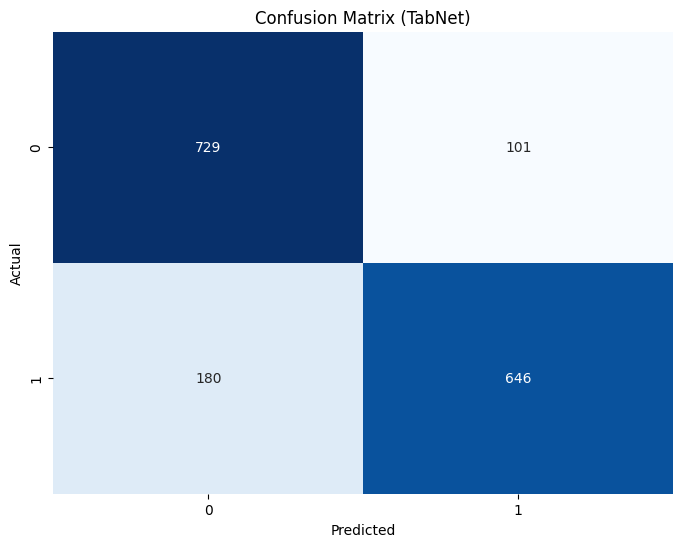

In [60]:
cm1 = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (TabNet)')
plt.show()

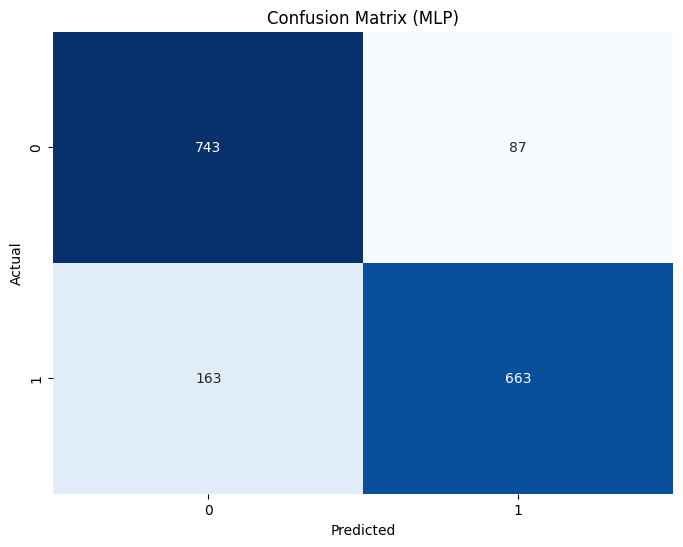

In [61]:
cm2 = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (MLP)')
plt.show()

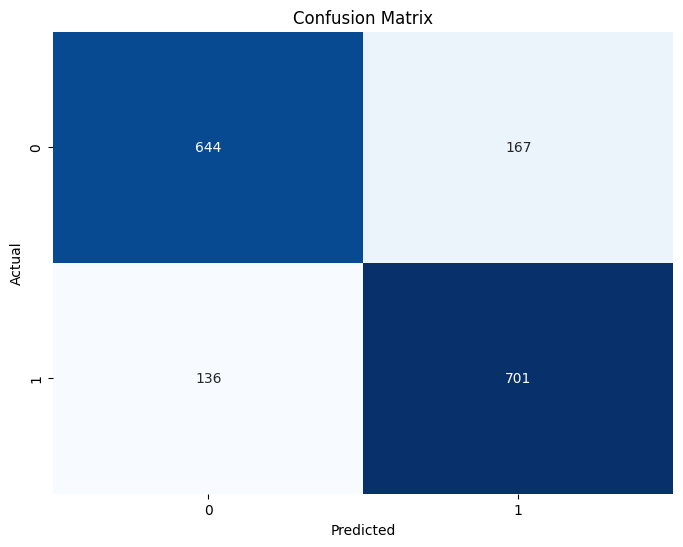

In [62]:
cm3 = confusion_matrix(y_true, y_pred3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**ROC**

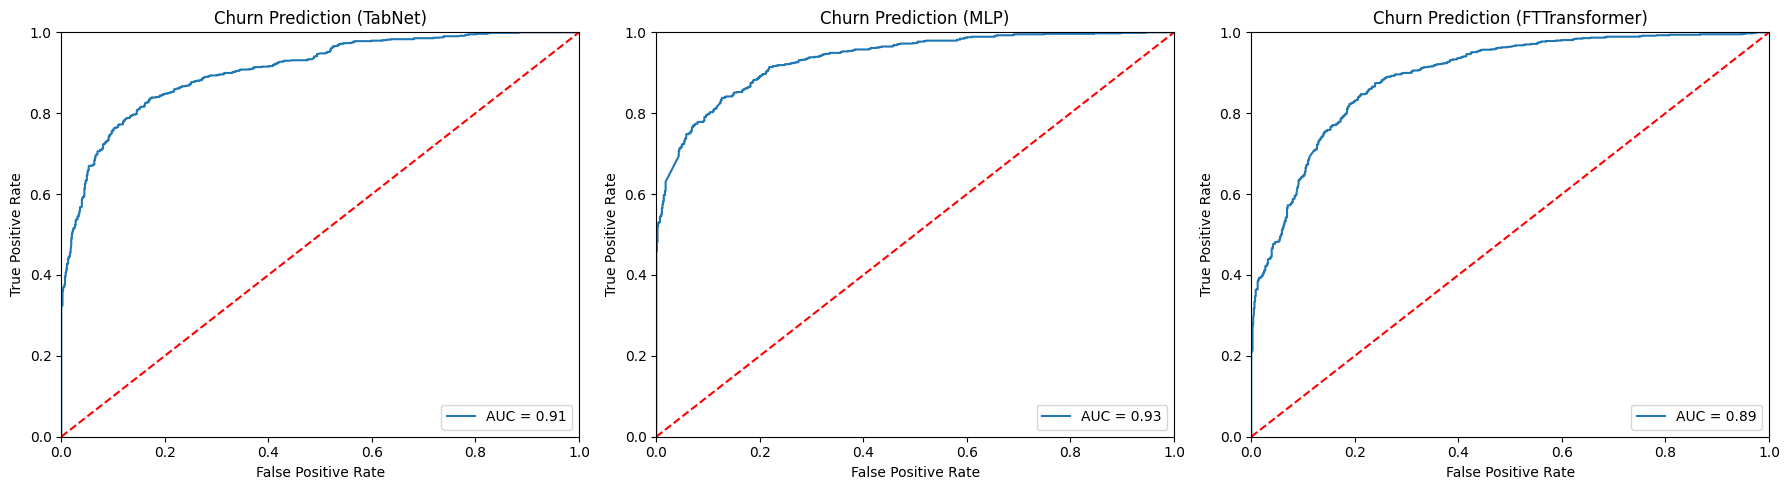

In [67]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr1, tpr1, _ = roc_curve(y_test, y_proba)          # TabNet
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, preds2)        # MLP
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_true, y_prob)       # FTTransformer
roc_auc3 = auc(fpr3, tpr3)

# Tạo figure với 3 subplot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 hàng, 3 cột

# ROC - TabNet
axs[0].plot(fpr1, tpr1, label='AUC = %0.2f' % roc_auc1)
axs[0].plot([0, 1], [0, 1], 'r--')
axs[0].set_title('Churn Prediction (TabNet)')
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc='lower right')

# ROC - MLP
axs[1].plot(fpr2, tpr2, label='AUC = %0.2f' % roc_auc2)
axs[1].plot([0, 1], [0, 1], 'r--')
axs[1].set_title('Churn Prediction (MLP)')
axs[1].set_xlim([0, 1])
axs[1].set_ylim([0, 1])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend(loc='lower right')

# ROC - FTTransformer
axs[2].plot(fpr3, tpr3, label='AUC = %0.2f' % roc_auc3)
axs[2].plot([0, 1], [0, 1], 'r--')
axs[2].set_title('Churn Prediction (FTTransformer)')
axs[2].set_xlim([0, 1])
axs[2].set_ylim([0, 1])
axs[2].set_xlabel('False Positive Rate')
axs[2].set_ylabel('True Positive Rate')
axs[2].legend(loc='lower right')

plt.tight_layout()
plt.show()


**LIME**

In [68]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=908b1bd1d2a162c526b039f0c5da4e3d5ead882bb9255a141c32904fcf44ed06
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [84]:
from lime import lime_tabular

# Tên cột đặc trưng (không có cột "Churn")
def predict_proba(x):
    pred12 = mlp.predict(x)
    return np.hstack([1 - pred12, pred12])   # trả ra [p(0), p(1)]


# Khởi tạo LIME explainer
explainer1 = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Not Churn', 'Churn'],
    mode='classification',
    discretize_continuous=True
)

# Chọn 1 khách hàng trong tập test để phân tích

exp = explainer1.explain_instance(
    data_row=X_test.iloc[6],
    predict_fn=predict_proba,)
exp.show_in_notebook(show_table=True)


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

In [85]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[17],
    predict_fn=predict_proba,)
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

In [88]:
exp = explainer1.explain_instance(
    data_row=X_test.iloc[20],
    predict_fn=predict_proba,)
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

**SHAP**

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━

PermutationExplainer explainer:   4%|▍         | 4/100 [00:00<?, ?it/s]

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   6%|▌         | 6/100 [00:13<01:48,  1.16s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   7%|▋         | 7/100 [00:15<02:44,  1.77s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   8%|▊         | 8/100 [00:18<03:25,  2.23s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   9%|▉         | 9/100 [00:22<04:01,  2.65s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  10%|█         | 10/100 [00:25<04:03,  2.70s/it]

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  11%|█         | 11/100 [00:27<04:00,  2.70s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  12%|█▏        | 12/100 [00:30<03:47,  2.58s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  13%|█▎        | 13/100 [00:34<04:17,  2.96s/it]

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  14%|█▍        | 14/100 [00:36<04:10,  2.92s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  15%|█▌        | 15/100 [00:39<03:54,  2.76s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  16%|█▌        | 16/100 [00:41<03:37,  2.59s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  17%|█▋        | 17/100 [00:43<03:26,  2.49s/it]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  18%|█▊        | 18/100 [00:46<03:42,  2.72s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  19%|█▉        | 19/100 [00:49<03:48,  2.82s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  20%|██        | 20/100 [00:52<03:32,  2.66s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  21%|██        | 21/100 [00:54<03:21,  2.55s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  22%|██▏       | 22/100 [00:56<03:13,  2.48s/it]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  23%|██▎       | 23/100 [01:00<03:41,  2.87s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  24%|██▍       | 24/100 [01:03<03:43,  2.94s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  25%|██▌       | 25/100 [01:06<03:25,  2.74s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  26%|██▌       | 26/100 [01:08<03:19,  2.69s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  27%|██▋       | 27/100 [01:10<03:06,  2.55s/it]

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  28%|██▊       | 28/100 [01:14<03:31,  2.94s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  29%|██▉       | 29/100 [01:17<03:22,  2.85s/it]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  30%|███       | 30/100 [01:19<03:08,  2.70s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  31%|███       | 31/100 [01:22<03:02,  2.65s/it]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  32%|███▏      | 32/100 [01:24<03:01,  2.67s/it]

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  33%|███▎      | 33/100 [01:29<03:28,  3.12s/it]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  34%|███▍      | 34/100 [01:31<03:12,  2.92s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  35%|███▌      | 35/100 [01:34<03:05,  2.86s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  36%|███▌      | 36/100 [01:36<02:55,  2.73s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  37%|███▋      | 37/100 [01:39<02:52,  2.73s/it]

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  38%|███▊      | 38/100 [01:43<03:06,  3.01s/it]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  39%|███▉      | 39/100 [01:45<02:56,  2.89s/it]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  40%|████      | 40/100 [01:48<02:48,  2.80s/it]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  41%|████      | 41/100 [01:50<02:36,  2.65s/it]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  42%|████▏     | 42/100 [01:53<02:37,  2.71s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  43%|████▎     | 43/100 [01:56<02:44,  2.88s/it]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  44%|████▍     | 44/100 [01:59<02:34,  2.76s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  45%|████▌     | 45/100 [02:01<02:27,  2.68s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  46%|████▌     | 46/100 [02:04<02:21,  2.63s/it]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  47%|████▋     | 47/100 [02:08<02:41,  3.04s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  48%|████▊     | 48/100 [02:10<02:31,  2.91s/it]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  49%|████▉     | 49/100 [02:13<02:17,  2.70s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  50%|█████     | 50/100 [02:15<02:13,  2.68s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  51%|█████     | 51/100 [02:18<02:08,  2.62s/it]

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  52%|█████▏    | 52/100 [02:21<02:15,  2.83s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  53%|█████▎    | 53/100 [02:24<02:13,  2.85s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  54%|█████▍    | 54/100 [02:27<02:11,  2.85s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  55%|█████▌    | 55/100 [02:29<02:03,  2.74s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  56%|█████▌    | 56/100 [02:32<01:56,  2.66s/it]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  57%|█████▋    | 57/100 [02:36<02:09,  3.02s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  58%|█████▊    | 58/100 [02:38<02:02,  2.92s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  59%|█████▉    | 59/100 [02:41<01:56,  2.84s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  60%|██████    | 60/100 [02:43<01:49,  2.73s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  61%|██████    | 61/100 [02:46<01:41,  2.60s/it]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  62%|██████▏   | 62/100 [02:49<01:52,  2.95s/it]

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  63%|██████▎   | 63/100 [02:52<01:43,  2.81s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  64%|██████▍   | 64/100 [02:55<01:40,  2.79s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  65%|██████▌   | 65/100 [02:57<01:32,  2.64s/it]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  66%|██████▌   | 66/100 [03:00<01:30,  2.66s/it]

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  67%|██████▋   | 67/100 [03:04<01:41,  3.06s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  68%|██████▊   | 68/100 [03:06<01:35,  2.97s/it]

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  69%|██████▉   | 69/100 [03:09<01:27,  2.83s/it]

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  70%|███████   | 70/100 [03:11<01:20,  2.67s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  71%|███████   | 71/100 [03:15<01:28,  3.04s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  72%|███████▏  | 72/100 [03:18<01:25,  3.04s/it]

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  73%|███████▎  | 73/100 [03:21<01:18,  2.92s/it]

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  74%|███████▍  | 74/100 [03:23<01:10,  2.72s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  75%|███████▌  | 75/100 [03:25<01:04,  2.60s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  76%|███████▌  | 76/100 [03:30<01:13,  3.07s/it]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  77%|███████▋  | 77/100 [03:32<01:05,  2.85s/it]

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  78%|███████▊  | 78/100 [03:34<00:58,  2.67s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  79%|███████▉  | 79/100 [03:37<00:57,  2.76s/it]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  80%|████████  | 80/100 [03:40<00:53,  2.68s/it]

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  81%|████████  | 81/100 [03:43<00:57,  3.02s/it]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  82%|████████▏ | 82/100 [03:46<00:51,  2.86s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  83%|████████▎ | 83/100 [03:48<00:46,  2.76s/it]

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  84%|████████▍ | 84/100 [03:51<00:43,  2.72s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  85%|████████▌ | 85/100 [03:54<00:40,  2.70s/it]

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  86%|████████▌ | 86/100 [03:57<00:41,  2.94s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  87%|████████▋ | 87/100 [04:01<00:39,  3.07s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  88%|████████▊ | 88/100 [04:03<00:34,  2.90s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  89%|████████▉ | 89/100 [04:06<00:32,  2.95s/it]

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  90%|█████████ | 90/100 [04:10<00:32,  3.27s/it]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  91%|█████████ | 91/100 [04:13<00:27,  3.02s/it]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  92%|█████████▏| 92/100 [04:15<00:22,  2.85s/it]

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  93%|█████████▎| 93/100 [04:17<00:19,  2.72s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  94%|█████████▍| 94/100 [04:21<00:17,  2.88s/it]

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  95%|█████████▌| 95/100 [04:25<00:16,  3.21s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  96%|█████████▌| 96/100 [04:28<00:12,  3.17s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  97%|█████████▋| 97/100 [04:31<00:09,  3.16s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  98%|█████████▊| 98/100 [04:33<00:05,  2.93s/it]

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  99%|█████████▉| 99/100 [04:37<00:03,  3.14s/it]

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer: 100%|██████████| 100/100 [04:39<00:00,  2.98s/it]

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer: 101it [04:42,  2.91s/it]


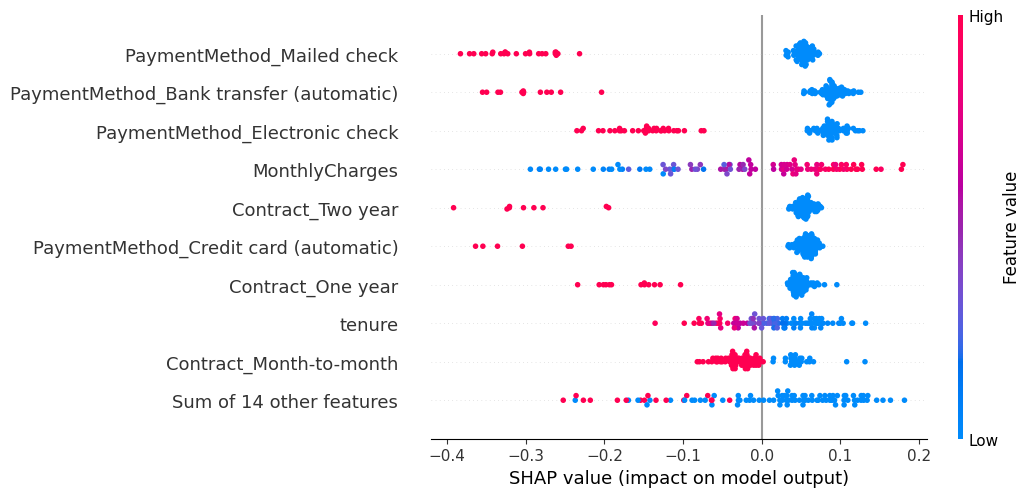

In [89]:
import shap

# 1. Tạo explainer (giả sử bạn dùng model Keras/MLP)
explainer2 = shap.Explainer(mlp.predict, X_train)  # hoặc X_test nếu bạn muốn

# 2. Tính SHAP values
shap_values = explainer2(X_test[0:100])

# 3. Vẽ biểu đồ tổng quan (summary)
shap.plots.beeswarm(shap_values)

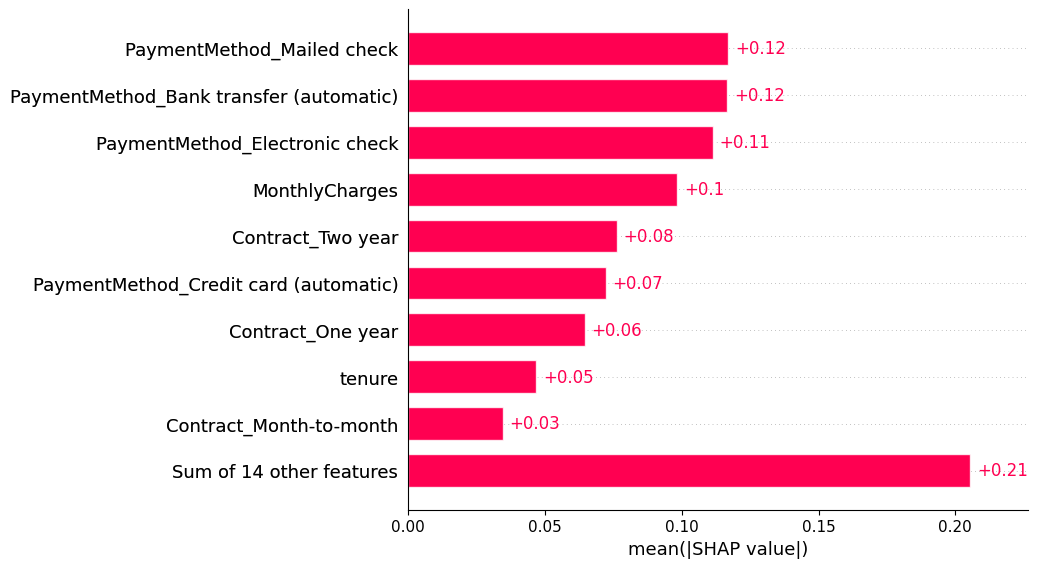

In [90]:
shap.plots.bar(shap_values)